In [50]:
import pandas_datareader.data as web
from datetime import datetime, date
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from tqdm import tqdm
import numpy as np
%matplotlib inline 
import statsmodels.api as sm
import os

pd.set_option('display.max_columns', None)


In [26]:
def get_risk_free_rate():
    """
    Obtiene el tipo de interés libre de riesgo (T-Bill 3M, ticker ^IRX) desde Yahoo Finance.
    Devuelve el valor diario equivalente (no anual).
    """
    t_bill = yf.Ticker("^IRX")
    data = t_bill.history(period="5d")  # últimos 5 días para evitar problemas de días festivos
    last_yield = data["Close"].iloc[-1] / 100.0  # convertir % a decimal
    
    # Pasar de anual a diario (252 días de mercado al año)
    risk_free_daily = (1 + last_yield) ** (1/252) - 1
    return risk_free_daily

def save_extraction_historic_parquet(data_his, path="data_historic"):
    os.makedirs(SUBFOLDER_DIR, exist_ok=True)
    for name, df in ibex35_df.items():
        df['share_name'] = name
        filename = name.lower().replace(' ', '_')
        df.to_parquet(f"{path}//{filename}.parquet", index=True)

def load_extraction_historic_parquet(path="data_historic"):
    data_his = {}
    for file in os.listdir(path):
        if file.endswith(".parquet"):
            name = file.replace(".parquet", "")
            df = pd.read_parquet(os.path.join(path, file))
            data_his[name] = df
    return data_his
    
def compute_sharpe_ratio(data, risk_free_rate = 0):
    mean_return = data["Daily Return"].mean()
    std = data["Daily Return"].std()
    sharpe_ratio = (mean_return-risk_free_rate) / std
    return sharpe_ratio

def compute_alpha_beta(stock_data, benchmark_data):
    """
    Calcula Alpha y Beta de un activo respecto a un benchmark.
    stock_data y benchmark_data deben ser Series con retornos diarios (%).
    """
    # Alinear índices de fechas
    data = pd.merge(
        stock_data.rename("stock"),
        benchmark_data.rename("benchmark"),
        left_index=True,
        right_index=True,
        how="left"
    ).dropna()

    stock_returns = data.iloc[:, 0].pct_change(1).dropna()
    benchmark_returns = data.iloc[:, 1].pct_change(1).dropna()

    # Regresión lineal: stock = alpha + beta * benchmark
    X = sm.add_constant(benchmark_returns)
    model = sm.OLS(stock_returns, X).fit()
    alpha, beta = model.params

    return alpha, beta

def call_yf_api_historic(start_period, end_period, ticker):
    data = yf.download(ticker, start_period , end_period, auto_adjust=True)
    data.columns = data.columns.droplevel('Ticker')
    data["Daily Return"] = data["Close"].pct_change(1)
    data = data.dropna()
    data["Cumulative Return"] = (1 + data["Daily Return"]).cumprod() - 1
    return data

def extraction_historic(start_period, end_period, tickers):
    data_his = {}
    
    for ticker in tqdm(tickers, desc="Procesando tickers"):
        name_ticker = tickers[ticker]
        data_his[name_ticker] = call_yf_api_historic(start_period, end_period, ticker)
    return data_his

def interpretar_recomendacion(val):
    if val is None:
        return None
    elif val < 1.5:
        return "Compra fuerte (Strong Buy)"
    elif val < 2.5:
        return "Compra (Buy)"
    elif val < 3.5:
        return "Mantener (Hold)"
    elif val < 4.5:
        return "Vender (Underperform / Sell)"
    else:
        return "Vender fuerte (Strong Sell)"

def interpretar_sharpe(sharpe):
    if sharpe is None or pd.isna(sharpe):
        return None
    elif sharpe < 0:
        return "Mala inversión (rinde peor que activo libre de riesgo)"
    elif sharpe < 1:
        return "Rentabilidad baja para el riesgo asumido"
    elif sharpe < 2:
        return "Aceptable"
    elif sharpe < 3:
        return "Buena"
    else:
        return "Excelente"

def analysis_stock_hist(df_raw, tickers, bechmark_df):
    # Valores posibles:
    
    # 👉 En teoría: puede ser cualquier número real (positivo, negativo o cercano a cero).
    # 🔴 < 0 → la inversión rinde peor que un activo libre de riesgo (mala señal).
    # 🟠 0 – 1 → rentabilidad baja respecto al riesgo, poco atractivo.
    # 🟡 1 – 2 → inversión aceptable/buena.
    # 🟢 2 – 3 → inversión muy buena.
    # 🟢 > 3 → inversión excelente (pocas veces se da en mercados reales).
    rows = []

    for name, df in tqdm(df_raw.items(), desc="Procesando tickers"):
        ticker = [k for k, v in tickers.items() if v == name][0]
        ret_1m = df["Cumulative Return"].iloc[-1]  # último valor
        ret_2m = df["Cumulative Return"].iloc[-31]  # último valor
        ret_3m = df["Cumulative Return"].iloc[-61]  # último valor
        precio_actual = df["Close"].iloc[-1]  # último valor
        ret_3m = df["Cumulative Return"].iloc[-61]  # último valor
        volatilidad = df["Daily Return"].std()
    
        company_data = yf.Ticker(ticker).info
        sector = company_data.get("sector")
        industry = company_data.get("industry")
        market_cap = company_data.get("marketCap")
        recommendation = company_data.get("recommendationMean")
        
        target_price = company_data.get("targetMeanPrice")
        recommendation_interpratation = interpretar_recomendacion(recommendation)
        
        sharpe_ratio = compute_sharpe_ratio(df)
        sharpe_interpretation = interpretar_sharpe(sharpe_ratio)

        alpha, beta_calculated = compute_alpha_beta(df["Close"], bechmark_df["Close"])

        # ➕ Nuevos ratios financieros
        dividend_yield = company_data.get("dividendYield")
        pe_trailing = company_data.get("trailingPE")
        pe_forward = company_data.get("forwardPE")
        pb = company_data.get("priceToBook")
        volume = company_data.get("volume")
        beta = company_data.get("volume")


        if target_price is not None:
            rentabilidad_prevista = round((target_price-precio_actual) / precio_actual * 100.0, 1)
        else:
            rentabilidad_prevista = None 
        rows.append({
            "Empresa": name,
            "Ticker": ticker,
            "Sector": sector,
            "Industria": industry,
            "Capitalización mercado": market_cap,
            "Retorno 1 mes": ret_1m,
            "Retorno 2 meses": ret_2m,
            "Retorno 3 meses": ret_3m,
            "Precio actual": precio_actual,
            "Precio objetivo analistas": target_price,
            "Rentabilidad prevista": rentabilidad_prevista,
            "Valoración analistas": recommendation,
            "Interpretacion recomendacion": recommendation_interpratation,
            "sharpe_ratio": sharpe_ratio,
            "Interpretacion Sharpe": sharpe_interpretation,
            "volatilidad": volatilidad,
            "alpha": alpha, 
            "beta_calculada": beta_calculated,
                    # 🔽 Ratios añadidos
            "Dividend Yield": dividend_yield,
            "P/E (Trailing)": pe_trailing,
            "P/E (Forward)": pe_forward,
            "P/B": pb,
            "Volumen": volume,
            "beta": beta,
        })
    df_ranking = pd.DataFrame(rows)
    return df_ranking.sort_values('Rentabilidad prevista', ascending=False)



In [3]:
get_risk_free_rate()

0.00015183181510480814

In [4]:
start_period = datetime(2025,1,1)
end_period =  datetime(2025,9,11)
ibex35_tickers = {
    "ANA.MC":  "Acciona",
    "ANE.MC":  "Acciona Energía",
    "ACX.MC":  "Acerinox",
    "ACS.MC":  "ACS",
    "AENA.MC": "Aena",
    "AMS.MC":  "Amadeus",
    "BBVA.MC": "BBVA",
    "BKT.MC":  "Bankinter",
    "CABK.MC": "CaixaBank",
    "CLNX.MC": "Cellnex Telecom",
    "COL.MC":  "Inmobiliaria Colonial",
    "ELE.MC":  "Endesa",
    "ENG.MC":  "Enagás",
    "FDR.MC":  "Fluidra",
    "FER.MC":  "Ferrovial",
    "GRF.MC":  "Grifols",
    "IAG.MC":  "IAG (International Airlines Group)",
    "IBE.MC":  "Iberdrola",
    "IDR.MC":  "Indra",
    "ITX.MC":  "Inditex",
    "LOG.MC":  "Logista",
    "MAP.MC":  "Mapfre",
    "MEL.MC":  "Meliá Hotels International",
    "MRL.MC":  "Merlin Properties",
    "MTS.MC":  "ArcelorMittal",
    "NTGY.MC": "Naturgy",
    "PUIG.MC": "Puig",
    "RED.MC":  "Redeia",
    "REP.MC":  "Repsol",
    "ROVI.MC": "Rovi",
    "SAB.MC":  "Banco Sabadell",
    "SAN.MC":  "Banco Santander",
    "SCYR.MC": "Sacyr",
    "SLR.MC":  "Solaria",
    "TEF.MC":  "Telefónica",
    "UNI.MC":  "Unicaja Banco"
}
bechmark_ibex35 = call_yf_api_historic(start_period, end_period, '^IBEX')
ibex35_df = extraction_historic(start_period, end_period, ibex35_tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed                                                                                                                                | 0/36 [00:00<?, ?it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 1/36 [00:00<00:07,  4.59it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 2/36 [00:00<00:06,  5.17it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 3/36 [00:00<00:06,  5.04it/s]
[*********************100%***********************] 

In [27]:
ibex35_analysed_df = analysis_stock_hist(ibex35_df, ibex35_tickers, bechmark_ibex35)

Procesando tickers: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:17<00:00,  2.11it/s]


In [28]:
ibex35_analysed_df.head()

,Empresa,Ticker,Sector,Industria,Capitalización mercado,Retorno 1 mes,Retorno 2 meses,Retorno 3 meses,Precio actual,Precio objetivo analistas,...,Interpretacion Sharpe,volatilidad,alpha,beta_calculada,Dividend Yield,P/E (Trailing),P/E (Forward),P/B,Volumen,beta
9,Cellnex Telecom,CLNX.MC,Real Estate,Real Estate Services,20549064704,-0.034148,0.006604,0.053773,30.100000,41.52174,...,Mala inversión (rinde peor que activo libre de...,0.017827,-0.000789,0.533687,0.21,79.342100,-177.352940,1.569250,805382.0,805382.0
29,Rovi,ROVI.MC,Healthcare,Drug Manufacturers - Specialty & Generic,3063855104,-0.056027,-0.122773,-0.139844,59.400002,79.41250,...,Mala inversión (rinde peor que activo libre de...,0.019837,-0.001027,0.616396,1.54,23.127415,22.103321,5.436065,185604.0,185604.0
15,Grifols,GRF.MC,Healthcare,Drug Manufacturers - General,7263119360,0.301020,0.429251,0.097187,12.160000,15.85833,...,Rentabilidad baja para el riesgo asumido,0.024829,0.000355,0.934830,1.24,27.295456,20.355934,1.581095,751214.0,751214.0
10,Inmobiliaria Colonial,COL.MC,Real Estate,REIT - Office,3467190528,0.132409,0.178630,0.190688,5.635000,7.03059,...,Rentabilidad baja para el riesgo asumido,0.013499,-0.000200,0.650703,5.32,7.337663,17.121212,0.604278,407839.0,407839.0
18,Indra,IDR.MC,Technology,Information Technology Services,6016310784,0.918757,1.136505,1.110465,32.779999,40.74615,...,Rentabilidad baja para el riesgo asumido,0.025139,0.002709,0.751872,0.74,15.944184,38.516853,4.189173,708978.0,708978.0


In [46]:
# Normalización ponderada corregida
ibex35_analysed_df["Peso_PE"] = (1 / ibex35_analysed_df["P/E (Trailing)"]) / (1 / ibex35_analysed_df["P/E (Trailing)"]).sum() * 80

ibex35_analysed_df["Peso_DY"] = (ibex35_analysed_df["Dividend Yield"] / ibex35_analysed_df["Dividend Yield"].sum()) * 40

ibex35_analysed_df["Peso_PB"] = (1 / ibex35_analysed_df["P/B"]) / (1 / ibex35_analysed_df["P/B"]).sum() * 20
# 🔹 Sumatorio total
ibex35_analysed_df["Puntuación_Total"] = (
    ibex35_analysed_df["Peso_PE"] +
    ibex35_analysed_df["Peso_DY"] +
    ibex35_analysed_df["Peso_PB"]
)

# 🔹 Ranking descendente (mejor empresa = mayor puntuación)
ibex35_analysed_df = ibex35_analysed_df.sort_values(by="Puntuación_Total", ascending=False)


In [47]:
ibex35_analysed_df

,Empresa,Ticker,Sector,Industria,Capitalización mercado,Retorno 1 mes,Retorno 2 meses,Retorno 3 meses,Precio actual,Precio objetivo analistas,...,Dividend Yield,P/E (Trailing),P/E (Forward),P/B,Volumen,beta,Peso_PE,Peso_DY,Peso_PB,Puntuación_Total
10,Inmobiliaria Colonial,COL.MC,Real Estate,REIT - Office,3467190528,0.132409,0.178630,0.190688,5.635000,7.03059,...,5.32,7.337663,17.121212,0.604278,407839.0,407839.0,4.243809,1.560804,1.521422,7.326034
35,Unicaja Banco,UNI.MC,Financial Services,Banks - Regional,6224904704,0.980342,0.917104,0.590930,2.380000,2.12824,...,5.88,10.100000,16.160000,0.892489,26931572.0,26931572.0,3.083132,1.725099,1.030110,5.838341
30,Banco Sabadell,SAB.MC,Financial Services,Banks - Diversified,16809233408,0.931874,0.746889,0.577600,3.364000,3.18875,...,5.75,9.294444,25.738462,1.224296,14204253.0,14204253.0,3.350350,1.686959,0.750931,5.788240
24,ArcelorMittal,MTS.MC,Basic Materials,Steel,22578911232,0.324420,0.267441,0.205976,29.520000,31.62500,...,1.77,10.560715,6.751141,0.413543,116049.0,116049.0,2.948630,0.519290,2.223133,5.691053
16,IAG (International Airlines Group),IAG.MC,Industrials,Airlines,20515598336,0.230223,0.193770,0.024384,4.421000,5.06667,...,2.04,6.830769,3.762712,3.482353,5844616.0,5844616.0,4.558730,0.598504,0.264006,5.421240
25,Naturgy,NTGY.MC,Utilities,Utilities - Regulated Gas,25363378176,0.143250,0.184299,0.138810,26.180000,26.37688,...,9.05,12.692308,18.857143,3.260064,340216.0,340216.0,2.453426,2.655127,0.282007,5.390560
6,BBVA,BBVA.MC,Financial Services,Banks - Diversified,94178304000,0.805408,0.515872,0.461654,16.150000,16.15938,...,4.32,9.295455,17.404257,1.720475,4629420.0,4629420.0,3.349985,1.267420,0.534365,5.151770
21,Mapfre,MAP.MC,Financial Services,Insurance - Diversified,11855326208,0.597969,0.470198,0.368977,3.852000,3.42300,...,4.87,11.022858,16.773912,1.318974,3598030.0,3598030.0,2.825006,1.428781,0.697028,4.950815
8,CaixaBank,CABK.MC,Financial Services,Banks - Regional,62632411136,0.761594,0.656340,0.481988,8.770000,8.47250,...,4.96,10.987654,21.707315,1.681148,3879928.0,3879928.0,2.834057,1.455186,0.546865,4.836108
23,Merlin Properties,MRL.MC,Real Estate,REIT - Office,7265928704,0.297671,0.194379,0.109137,12.940000,14.33889,...,3.08,10.848739,23.053572,0.921024,994871.0,994871.0,2.870346,0.903623,0.998195,4.772164


In [6]:
tickers_sp500 = {
    "AAPL": "Apple Inc.",
    "MSFT": "Microsoft Corporation",
    "NVDA": "NVIDIA Corporation",
    "GOOGL": "Alphabet Inc. (Clase A)",
    "AMZN": "Amazon.com, Inc.",
    "META": "Meta Platforms, Inc.",
    "TSLA": "Tesla, Inc.",
    "BRK-B": "Berkshire Hathaway Inc.",
    "JPM": "JPMorgan Chase & Co.",
    "V": "Visa Inc.",
    "LLY": "Eli Lilly and Co.",
    "JNJ": "Johnson & Johnson",
    "PG": "Procter & Gamble Co.",
    "UNH": "UnitedHealth Group Incorporated",
    "HD": "Home Depot, Inc.",
    "ABBV": "AbbVie Inc.",
    "BAC": "Bank of America Corporation",
    "KO": "Coca-Cola Company",
    "PEP": "PepsiCo, Inc.",
    "CRM": "Salesforce, Inc.",
    "ORCL": "Oracle Corporation",
    "CSCO": "Cisco Systems, Inc.",
    "TMO": "Thermo Fisher Scientific Inc.",
    "QCOM": "Qualcomm Incorporated",
    "ADBE": "Adobe Inc.",
    "INTC": "Intel Corporation",
    "TXN": "Texas Instruments Incorporated",
    "BLK": "BlackRock, Inc.",
    "LMT": "Lockheed Martin Corporation",
    "ABT": "Abbott Laboratories",
    "CAT": "Caterpillar Inc.",
    "MRK": "Merck & Co., Inc.",
    "AMGN": "Amgen Inc.",
    "MCD": "McDonald's Corporation",
    "NKE": "Nike, Inc.",
    "XOM": "Exxon Mobil Corporation",
    "WMT": "Walmart Inc.",
    "JCI": "Johnson Controls International plc",
    "GE": "General Electric Company",
    "MMM": "3M Company",
    "PFE": "Pfizer Inc.",
    "CVS": "CVS Health Corporation",
    "CL": "Colgate-Palmolive Company",
    "DIS": "Walt Disney Company",
    "RTX": "RTX Corporation",
    "UBER": "Uber Technologies, Inc.",
    "NOW": "ServiceNow, Inc.",
    "SPGI": "S&P Global Inc.",
    "MDT": "Medtronic plc",
    "NEE": "NextEra Energy, Inc.",
    "LOW": "Lowe's Companies, Inc.",
    "PYPL": "PayPal Holdings, Inc.",
    "INTU": "Intuit Inc.",
    "ADP": "Automatic Data Processing, Inc.",
    "ISRG": "Intuitive Surgical, Inc.",
    "AMT": "American Tower Corporation",
    "CSX": "CSX Corporation",
    "DUK": "Duke Energy Corporation",
}

bechmark_sp500 = call_yf_api_historic(start_period, end_period, '^GSPC')
sp500_df = extraction_historic(start_period, end_period, tickers_sp500)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed                                                                                                                                | 0/58 [00:00<?, ?it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 1/58 [00:00<00:13,  4.27it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 2/58 [00:00<00:12,  4.64it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 3/58 [00:00<00:11,  4.85it/s]
[*********************100%***********************] 

In [29]:
sp500_analysed_df = analysis_stock_hist(sp500_df, tickers_sp500, bechmark_sp500)

Procesando tickers: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:27<00:00,  2.15it/s]


In [48]:
# Normalización ponderada corregida
sp500_analysed_df["Peso_PE"] = (1 / sp500_analysed_df["P/E (Trailing)"]) / (1 / sp500_analysed_df["P/E (Trailing)"]).sum() * 80

sp500_analysed_df["Peso_DY"] = (sp500_analysed_df["Dividend Yield"] / sp500_analysed_df["Dividend Yield"].sum()) * 40

sp500_analysed_df["Peso_PB"] = (1 / sp500_analysed_df["P/B"]) / (1 / sp500_analysed_df["P/B"]).sum() * 20
# 🔹 Sumatorio total
sp500_analysed_df["Puntuación_Total"] = (
    sp500_analysed_df["Peso_PE"] +
    sp500_analysed_df["Peso_DY"] +
    sp500_analysed_df["Peso_PB"]
)

# 🔹 Ranking descendente (mejor empresa = mayor puntuación)
sp500_analysed_df = sp500_analysed_df.sort_values(by="Puntuación_Total", ascending=False)


In [51]:
sp500_analysed_df.head(10)

,Empresa,Ticker,Sector,Industria,Capitalización mercado,Retorno 1 mes,Retorno 2 meses,Retorno 3 meses,Precio actual,Precio objetivo analistas,Rentabilidad prevista,Valoración analistas,Interpretacion recomendacion,sharpe_ratio,Interpretacion Sharpe,volatilidad,alpha,beta_calculada,Dividend Yield,P/E (Trailing),P/E (Forward),P/B,Volumen,beta,Peso_PE,Peso_DY,Peso_PB,Puntuación_Total
40,Pfizer Inc.,PFE,Healthcare,Drug Manufacturers - General,136282628096,-0.026988,-0.037680,-0.044660,24.570000,28.85714,17.4,2.43478,Compra (Buy),-0.002212,Mala inversión (rinde peor que activo libre de...,0.015834,-0.000320,0.447734,7.21,12.682539,8.180887,1.536341,50551378,50551378,2.786597,2.861679,0.013618,5.661894
31,"Merck & Co., Inc.",MRK,Healthcare,Drug Manufacturers - General,202370121728,-0.136790,-0.151172,-0.168943,84.029999,102.33333,21.8,1.96296,Compra (Buy),-0.035852,Mala inversión (rinde peor que activo libre de...,0.018943,-0.000923,0.374457,3.91,12.483821,8.619149,4.139376,8832340,8832340,2.830954,1.551895,0.005054,4.387904
35,Exxon Mobil Corporation,XOM,Energy,Oil & Gas Integrated,478976114688,0.077417,0.071090,0.063878,112.500000,125.08333,11.2,2.24000,Compra (Buy),0.035101,Rentabilidad baja para el riesgo asumido,0.016161,0.000162,0.586121,3.53,15.958807,14.275731,1.824012,12876961,12876961,2.214522,1.401072,0.011470,3.627064
13,UnitedHealth Group Incorporated,UNH,Healthcare,Healthcare Plans,315074936832,-0.304802,-0.476627,-0.375890,346.779999,338.33334,-2.4,1.96154,Compra (Buy),-0.043251,Mala inversión (rinde peor que activo libre de...,0.034526,-0.001761,0.247713,2.51,15.066696,11.635118,3.323779,10464018,10464018,2.345645,0.996229,0.006295,3.348169
16,Bank of America Corporation,BAC,Financial Services,Banks - Diversified,374717612032,0.152086,0.095890,0.007670,50.130001,53.52083,6.8,1.60000,Compra (Buy),0.053856,Rentabilidad baja para el riesgo asumido,0.018661,0.000271,1.039797,2.21,14.835776,13.822404,1.362620,29038625,29038625,2.382156,0.877158,0.015354,3.274668
57,Duke Energy Corporation,DUK,Utilities,Utilities - Regulated Electric,95157854208,0.156144,0.128666,0.103824,121.349998,132.00000,8.8,2.16667,Compra (Buy),0.080248,Rentabilidad baja para el riesgo asumido,0.011382,0.000931,-0.015870,3.49,20.027822,19.301262,1.907204,1524723,1524723,1.764602,1.385195,0.010970,3.160767
41,CVS Health Corporation,CVS,Healthcare,Healthcare Plans,93171515392,0.730162,0.403403,0.560869,73.970001,82.07250,11.0,1.65385,Compra (Buy),0.155064,Rentabilidad baja para el riesgo asumido,0.022260,0.003065,0.311462,3.55,20.462397,11.336419,1.202823,6962000,6962000,1.727125,1.409010,0.017394,3.153529
23,Qualcomm Incorporated,QCOM,Technology,Semiconductors,173956399104,0.052343,0.066993,0.018541,158.949997,178.19630,12.1,2.25000,Compra (Buy),0.024348,Rentabilidad baja para el riesgo asumido,0.024754,-0.000491,1.452217,2.20,15.561777,13.182339,6.422852,5598828,5598828,2.271021,0.873189,0.003257,3.147468
11,Johnson & Johnson,JNJ,Healthcare,Drug Manufacturers - General,427239505920,0.250021,0.186699,0.108979,175.789993,177.46826,1.0,2.25000,Compra (Buy),0.104261,Rentabilidad baja para el riesgo asumido,0.013384,0.001361,0.055103,2.92,18.973260,16.735847,5.440883,3888072,3888072,1.862681,1.158960,0.003845,3.025486
8,JPMorgan Chase & Co.,JPM,Financial Services,Banks - Diversified,849397743616,0.272572,0.257752,0.116495,300.540009,306.17392,1.9,2.28000,Compra (Buy),0.092501,Rentabilidad baja para el riesgo asumido,0.016771,0.000828,1.011104,1.82,15.849153,18.452808,2.521386,7116796,7116796,2.229843,0.722366,0.008298,2.960506


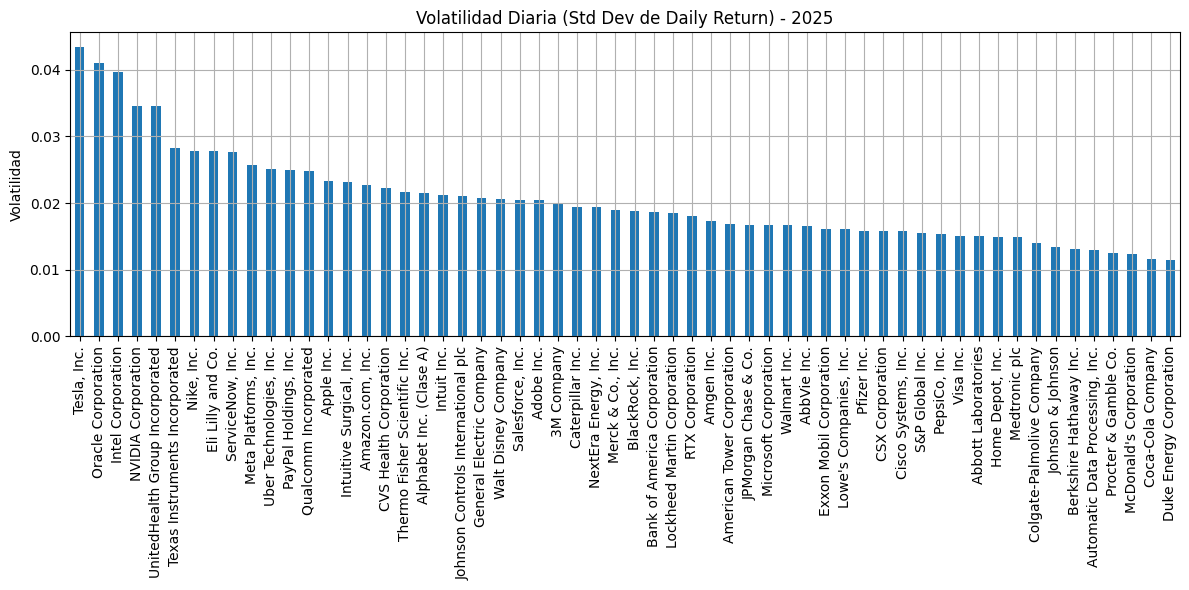

In [8]:
volatilities = {
    ticker: data["Daily Return"].std() for ticker, data in sp500_df.items()
}

# Convertir a DataFrame y graficar
vol_df = pd.DataFrame.from_dict(volatilities, orient='index', columns=["Volatilidad"])
vol_df.sort_values("Volatilidad", ascending=False).plot(kind='bar', figsize=(12, 6), legend=False)

plt.title("Volatilidad Diaria (Std Dev de Daily Return) - 2025")
plt.ylabel("Volatilidad")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
start_period = datetime(2024,1,1)
end_period =  datetime(2025,9,11)

tickers_index = {
    "IWDA.AS": "MSCI World",
    "CSPX.AS": "S&P 500",
    "CS1.PA": "IBEX 35",
    "EUNK.DE": "Core MSCI Europe",
    "LYP6.DE": "Stoxx Europe 600",
    '^GSPC': "SP500 Index"
}

bechmark_sp500 = call_yf_api_historic(start_period, end_period, '^GSPC')
index_hist_df = extraction_historic(start_period, end_period, tickers_index)
index_analysed_df = analysis_stock_hist(index_hist_df, tickers_index, bechmark_sp500)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed                                                                                                                                 | 0/6 [00:00<?, ?it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                         | 1/6 [00:00<00:00,  5.42it/s]
[*********************100%***********************]  1 of 1 completed███████████▋                                                                                                             | 2/6 [00:00<00:00,  5.01it/s]
[*********************100%***********************]  1 of 1 completed███████████████████████████████████████                                                                                  | 3/6 [00:00<00:00,  4.96it/s]
[*********************100%***********************] 

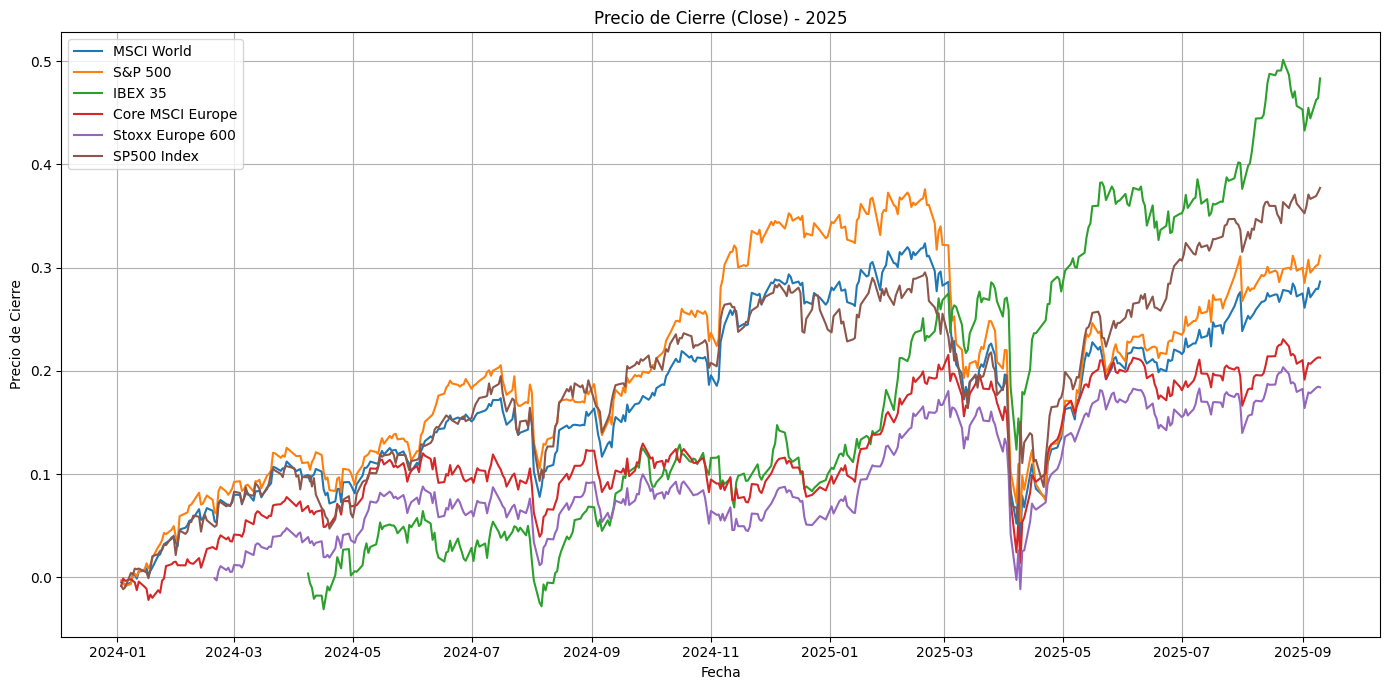

In [10]:
plt.figure(figsize=(14, 7))

for ticker, data in index_hist_df.items():
    plt.plot(data.index, data["Cumulative Return"], label=ticker)

plt.title("Precio de Cierre (Close) - 2025")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

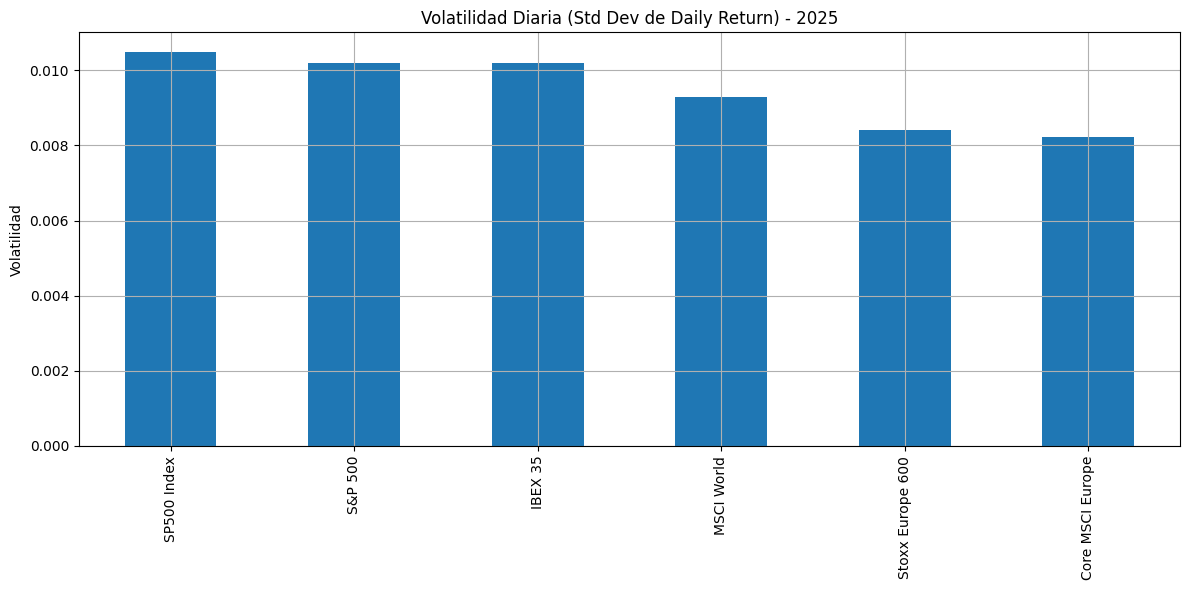

In [11]:
volatilities = {
    ticker: data["Daily Return"].std() for ticker, data in index_hist_df.items()
}

# Convertir a DataFrame y graficar
vol_df = pd.DataFrame.from_dict(volatilities, orient='index', columns=["Volatilidad"])
vol_df.sort_values("Volatilidad", ascending=False).plot(kind='bar', figsize=(12, 6), legend=False)

plt.title("Volatilidad Diaria (Std Dev de Daily Return) - 2025")
plt.ylabel("Volatilidad")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
index_analysed_df

,Empresa,Ticker,Sector,Industria,Capitalización mercado,Retorno 1 mes,Retorno 2 meses,Retorno 3 meses,Precio actual,Precio objetivo analistas,Rentabilidad prevista,Valoración analistas,Interpretacion recomendacion,sharpe_ratio,Interpretacion Sharpe,volatilidad,alpha,beta
0,MSCI World,IWDA.AS,None,None,None,0.286566,0.273429,0.208235,105.775002,None,None,None,None,0.067526,Rentabilidad baja para el riesgo asumido,0.009280,3.819408e-04,0.330933
1,S&P 500,CSPX.AS,None,None,None,0.311632,0.303951,0.222306,595.935974,None,None,None,None,0.066681,Rentabilidad baja para el riesgo asumido,0.010202,4.174295e-04,0.349087
2,IBEX 35,CS1.PA,None,None,None,0.483292,0.401944,0.344865,382.000000,None,None,None,None,0.110905,Rentabilidad baja para el riesgo asumido,0.010187,1.015998e-03,0.204580
3,Core MSCI Europe,EUNK.DE,None,None,None,0.212937,0.203220,0.182537,87.379997,None,None,None,None,0.058863,Rentabilidad baja para el riesgo asumido,0.008222,3.466624e-04,0.206632
4,Stoxx Europe 600,LYP6.DE,None,None,None,0.184134,0.177654,0.153967,264.950012,None,None,None,None,0.054978,Rentabilidad baja para el riesgo asumido,0.008410,3.061573e-04,0.226598
5,SP500 Index,^GSPC,None,None,None,0.377245,0.343261,0.260212,6532.040039,None,None,None,None,0.077396,Rentabilidad baja para el riesgo asumido,0.010486,1.626303e-19,1.000000


In [13]:
start_period = datetime(2024,5,1)
end_period =  datetime(2025,9,11)

tickers_portafolio = {
    "GOOG": "Alphabet (Google)",
    "AMZN": "Amazon",
    #"ASTS": "AST SpaceMobile",
    "BRK-B": "Berkshire Hathaway B",
    "IWDA.AS": "MSCI World (iShares)",
    "CSPX.AS": "S&P 500 (iShares)",
    "HUBS": "HubSpot",
    "IAG.MC": "IAG (Iberia)",
    "CS1.PA": "CAC 40 / IBEX ETF",
    "ITX.MC": "Inditex",
    "MSFT": "Microsoft",
    "NVDA": "NVIDIA",
    "SNY": "Sanofi",
    "UNH": "UnitedHealth",
    "^GSPC": "benchmark_sp500",
    "^IBEX": "benchmark_ibex35",
}

bechmark_sp500 = call_yf_api_historic(start_period, end_period, '^GSPC')
portafolio_hist_df = extraction_historic(start_period, end_period, tickers_portafolio)
portafolio_analysed_df = analysis_stock_hist(portafolio_hist_df, tickers_portafolio, bechmark_sp500)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed                                                                                                                                | 0/15 [00:00<?, ?it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 1/15 [00:00<00:03,  4.50it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 2/15 [00:00<00:02,  5.08it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 3/15 [00:00<00:02,  5.17it/s]
[*********************100%***********************] 

In [14]:
portafolio_analysed_df

,Empresa,Ticker,Sector,Industria,Capitalización mercado,Retorno 1 mes,Retorno 2 meses,Retorno 3 meses,Precio actual,Precio objetivo analistas,Rentabilidad prevista,Valoración analistas,Interpretacion recomendacion,sharpe_ratio,Interpretacion Sharpe,volatilidad,alpha,beta
5,HubSpot,HUBS,Technology,Software - Application,2.677547e+10,-0.192892,-0.095299,-0.084971,489.179993,699.84000,43.1,1.37143,Compra fuerte (Strong Buy),-0.010193,Mala inversión (rinde peor que activo libre de...,0.026728,-1.292765e-03,1.346010
11,Sanofi,SNY,Healthcare,Drug Manufacturers - General,1.141775e+11,0.026126,0.073777,0.080740,47.160000,61.61111,30.6,1.70000,Compra (Buy),0.012843,Rentabilidad baja para el riesgo asumido,0.016307,2.174799e-05,0.273151
9,Microsoft,MSFT,Technology,Software - Infrastructure,3.830758e+12,0.281071,0.310152,0.214019,500.369995,615.38390,23.0,1.26316,Compra fuerte (Strong Buy),0.056603,Rentabilidad baja para el riesgo asumido,0.014788,2.126548e-05,0.980561
10,NVIDIA,NVDA,Technology,Semiconductors,4.327679e+12,1.136302,1.114376,0.710318,177.320007,208.59184,17.6,1.38462,Compra fuerte (Strong Buy),0.083176,Rentabilidad baja para el riesgo asumido,0.033679,9.840711e-04,2.125635
6,IAG (Iberia),IAG.MC,Industrials,Airlines,2.051560e+10,1.182245,1.117582,0.817115,4.421000,5.06667,14.6,1.66667,Compra (Buy),0.118069,Rentabilidad baja para el riesgo asumido,0.020853,2.232696e-03,0.421290
1,Amazon,AMZN,Consumer Cyclical,Internet Retail,2.468178e+12,0.286760,0.290559,0.184916,230.330002,263.73770,14.5,1.33333,Compra fuerte (Strong Buy),0.046339,Rentabilidad baja para el riesgo asumido,0.020554,-2.594021e-04,1.379118
8,Inditex,ITX.MC,Consumer Cyclical,Apparel Retail,1.445996e+11,0.093258,0.030931,0.069194,45.430000,50.38261,10.9,2.04348,Compra (Buy),0.024877,Rentabilidad baja para el riesgo asumido,0.014584,1.128764e-04,0.306639
2,Berkshire Hathaway B,BRK-B,Financial Services,Insurance - Diversified,1.060267e+12,0.229565,0.195645,0.223192,490.079987,521.00000,6.3,NaN,None,0.058433,Rentabilidad baja para el riesgo asumido,0.011546,2.141045e-04,0.550937
12,UnitedHealth,UNH,Healthcare,Healthcare Plans,3.150749e+11,-0.267053,-0.448208,-0.342001,346.779999,338.33334,-2.4,1.96154,Compra (Buy),-0.018790,Mala inversión (rinde peor que activo libre de...,0.027494,-7.674959e-04,0.240493
0,Alphabet (Google),GOOG,Communication Services,Internet Content & Information,3.040757e+12,0.456782,0.193438,0.068584,239.559998,227.61578,-5.0,1.54545,Compra (Buy),0.068333,Rentabilidad baja para el riesgo asumido,0.018768,3.690536e-04,1.065588


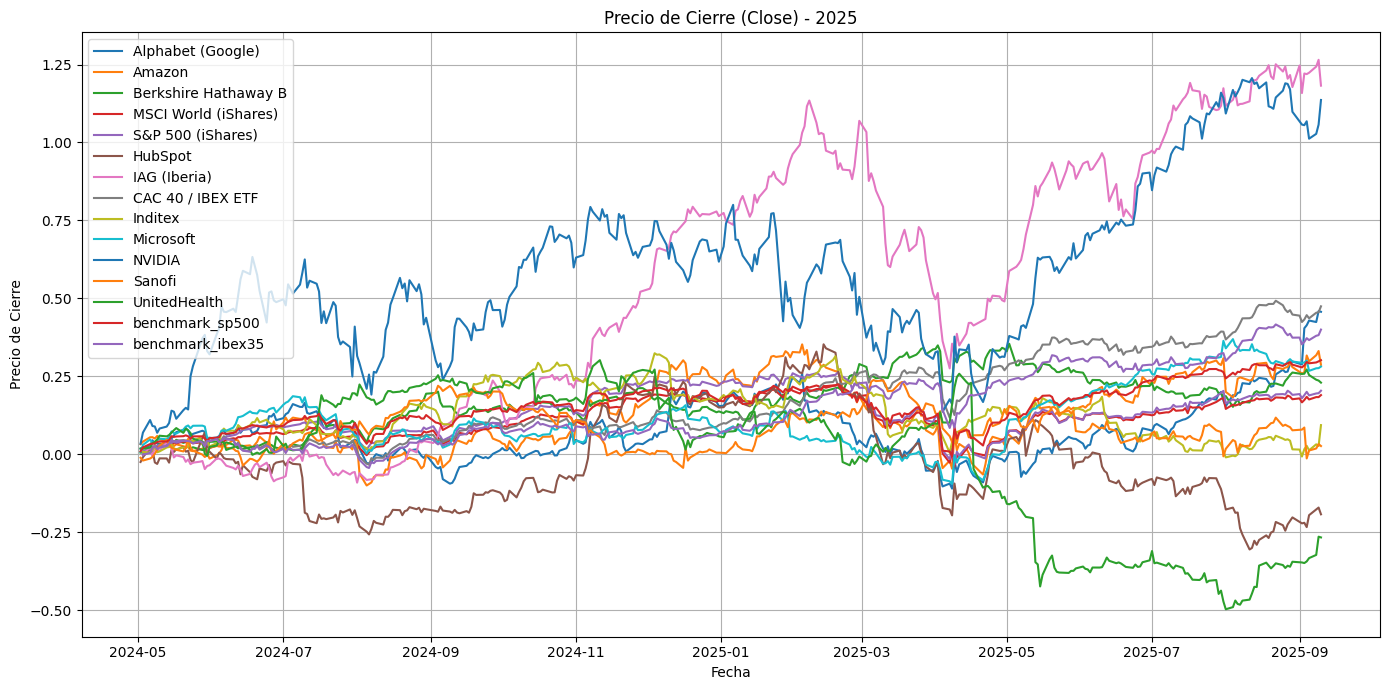

In [15]:
plt.figure(figsize=(14, 7))

for ticker, data in portafolio_hist_df.items():
    plt.plot(data.index, data["Cumulative Return"], label=ticker)

plt.title("Precio de Cierre (Close) - 2025")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

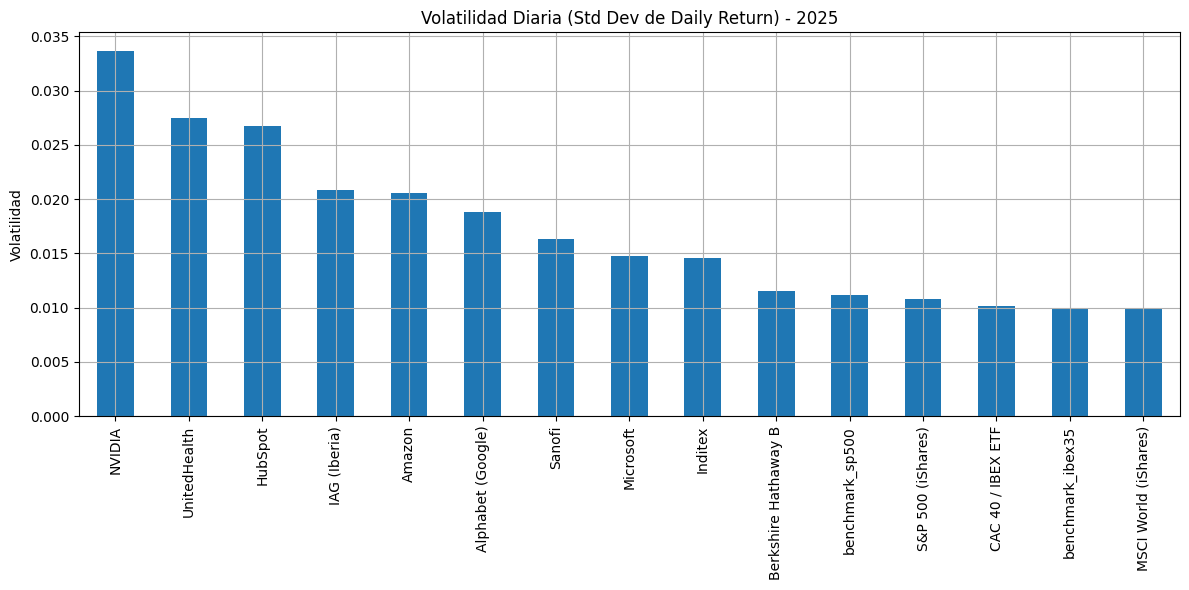

In [16]:
volatilities = {
    ticker: data["Daily Return"].std() for ticker, data in portafolio_hist_df.items()
}

# Convertir a DataFrame y graficar
vol_df = pd.DataFrame.from_dict(volatilities, orient='index', columns=["Volatilidad"])
vol_df.sort_values("Volatilidad", ascending=False).plot(kind='bar', figsize=(12, 6), legend=False)

plt.title("Volatilidad Diaria (Std Dev de Daily Return) - 2025")
plt.ylabel("Volatilidad")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
import statsmodels.api as sm

def compute_alpha_beta(stock_data, benchmark_data):
    """
    Calcula Alpha y Beta de un activo respecto a un benchmark.
    stock_data y benchmark_data deben ser Series con retornos diarios (%).
    """
    # Alinear índices de fechas
    data = pd.concat([stock_data, benchmark_data], axis=1).dropna()
    stock_returns = data.iloc[:, 0]
    benchmark_returns = data.iloc[:, 1]

    # Regresión lineal: stock = alpha + beta * benchmark
    X = sm.add_constant(benchmark_returns)
    model = sm.OLS(stock_returns, X).fit()
    alpha, beta = model.params

    return alpha, beta

In [18]:
stock_data = portafolio_hist_df['S&P 500 (iShares)']["Daily Return"]
benchmark_data = portafolio_hist_df['benchmark_sp500']["Daily Return"]

In [19]:
compute_alpha_beta(portafolio_hist_df['Alphabet (Google)']["Daily Return"], portafolio_hist_df['benchmark_sp500']["Daily Return"])

(0.00038947788739668277, 1.0670443983739248)

In [20]:
stock_data = ibex35_df['Banco Sabadell']["Daily Return"]
benchmark_data = bechmark_ibex35["Daily Return"]

data = pd.merge(
        stock_data.rename("stock"),
        benchmark_data.rename("benchmark"),
        left_index=True,
        right_index=True,
        how="left"
    ).dropna()

stock_returns = data.iloc[:, 0]
benchmark_returns = data.iloc[:, 1]

# Regresión lineal: stock = alpha + beta * benchmark
X = sm.add_constant(benchmark_returns)
model = sm.OLS(stock_returns, X).fit()
alpha, beta = model.params

/tmp/ipykernel_5248/1285566722.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range


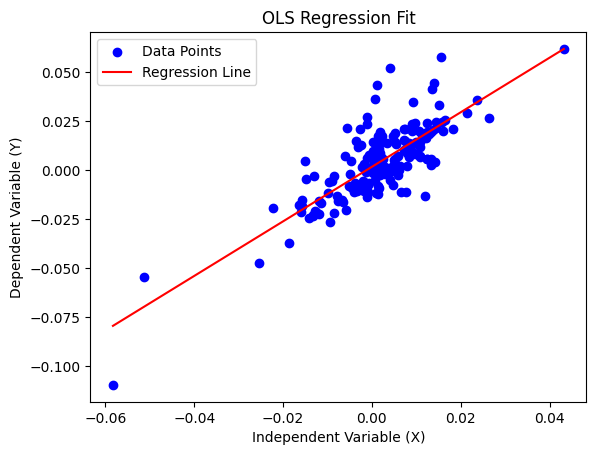

In [21]:
plt.scatter(benchmark_returns, stock_returns, color='blue', label='Data Points')

x_range = np.linspace(benchmark_returns.min(), benchmark_returns.max(), 100)
y_pred = model.params[0] + model.params[1] * x_range 

plt.plot(x_range, y_pred, color='red', label='Regression Line')
plt.xlabel('Independent Variable (X)')
plt.ylabel('Dependent Variable (Y)')
plt.title('OLS Regression Fit')
plt.legend()
plt.show()

In [22]:
stock_data = sp500_df['Alphabet Inc. (Clase A)']["Close"]
benchmark_data = bechmark_sp500["Close"]

data = pd.merge(
        stock_data.rename("stock"),
        benchmark_data.rename("benchmark"),
        left_index=True,
        right_index=True,
        how="left"
    ).dropna()

stock_returns = data.iloc[:, 0].pct_change(1).dropna()
benchmark_returns = data.iloc[:, 1].pct_change(1).dropna()

# Regresión lineal: stock = alpha + beta * benchmark
X = sm.add_constant(benchmark_returns)
model = sm.OLS(stock_returns, X).fit()
alpha, beta = model.params

/tmp/ipykernel_5248/1285566722.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range


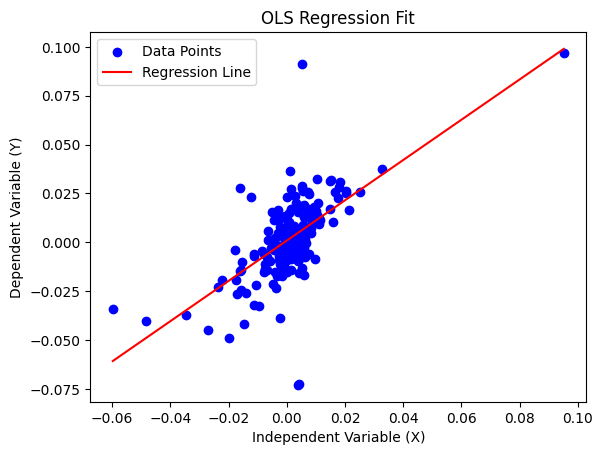

In [23]:
plt.scatter(benchmark_returns, stock_returns, color='blue', label='Data Points')

x_range = np.linspace(benchmark_returns.min(), benchmark_returns.max(), 100)
y_pred = model.params[0] + model.params[1] * x_range 

plt.plot(x_range, y_pred, color='red', label='Regression Line')
plt.xlabel('Independent Variable (X)')
plt.ylabel('Dependent Variable (Y)')
plt.title('OLS Regression Fit')
plt.legend()
plt.show()

In [24]:
subfolder = 'ibex35'
SUBFOLDER_DIR = os.path.join(DATA_DIR, subfolder)

def save_extraction_historic_parquet(data_his, path="data_historic"):
    os.makedirs(SUBFOLDER_DIR, exist_ok=True)
    for name, df in ibex35_df.items():
        df['share_name'] = name
        filename = name.lower().replace(' ', '_')
        df.to_parquet(f"{SUBFOLDER_DIR}//{filename}.parquet", index=True)


NameError: name 'os' is not defined

In [ ]:


def save_extraction_historic_parquet(data_his, path="data_historic"):
    os.makedirs(SUBFOLDER_DIR, exist_ok=True)
    for name, df in ibex35_df.items():
        df['share_name'] = name
        filename = name.lower().replace(' ', '_')
        df.to_parquet(f"{path}//{filename}.parquet", index=True)

def load_extraction_historic_parquet(path="data_historic"):
    data_his = {}
    for file in os.listdir(path):
        if file.endswith(".parquet"):
            name = file.replace(".parquet", "")
            df = pd.read_parquet(os.path.join(path, file))
            data_his[name] = df
    return data_his

In [ ]:
data_his = load_extraction_historic_parquet(SUBFOLDER_DIR)

In [ ]:
save_extraction_historic_parquet(ibex35_df, SUBFOLDER_DIR)